In [1]:
import pandas as pd
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

### Carga dataset

In [2]:
SEED = 42
np.random.seed(SEED)

### X = HGT
X_dir = "/opt/datos/dataset/sin_normalizar/X.npy"
X = np.load(X_dir)

print("X: %s" %str(X.shape))

### Y = lluvia (mm)
Y_dir = "/opt/datos/dataset/milimetros/Y.npy"
Y = np.load(Y_dir)

print("Y: %s" %str(Y.shape))

X: (11928, 3, 176, 176)
Y: (11928, 176, 176)


### Normalización y parametros

In [3]:
def params_entropy(u:np.array, m:int, r_rate:float):
    """        
    Calculates approximate entropy (ApEn) of a time series.

    Input
      u: Raw time series
      m: Template length
      r_rate: Constant for r compute

    Output: 
      u: Normalized time series
      m: Template length
      r: Tolerance level
    """

    # Normalize time series
    u_mean = np.mean(u)
    u_std = np.std(u)
    u = u-u_mean/u_std
    u = np.array(u)

    # Compute r
    r = r_rate*u_std

    return u, m, r

In [4]:
from typing import Callable
import time

def compute_time(func: Callable, u:np.array, m:int, r_rate:float)->float:
    """        
    Calculate execution time of function. 
    The function parameters are necessary.

    Input
    func: Function to test
    u: Raw time series
    m: Template length
    r_rate: Tolerance level

    Output: 
    t: Time execution of function
    """
    # start
    s = time.time()
    # compute
    func(u, m, r)
    # end
    e = time.time()
    # result
    t = e-s
    return t

### ApEn

In [5]:
def apen_cp(L, m, r) -> float:
    """        
    Calculates approximate entropy (ApEn) of a time series.

    Input
        L: Time series
        m: Template length
        r: Tolerance level

    Output: 
        ApEn
    """
  
    N = len(L)

    # Divide time series and save all templates of length m
    xmi = cp.array([L[i:i+m] for i in range(N-m)])
    xmj = cp.array([L[i:i+m] for i in range(N-m+1)])

    # Compute each B_i            
    B = cp.array([cp.sum(cp.abs(xmii-xmj).max(axis=1) <= r) for xmii in xmi])

    # Similar method to compute each A_i
    m += 1
    xm = cp.array([L[i:i+m] for i in range(N-m+1)])

    A = cp.array([cp.sum(cp.abs(xmi-xm).max(axis=1) <= r) for xmi in xm])
      
    # Compute and return ApEn
    m -= 1
    ApEn = -cp.sum(cp.log(cp.divide(A,B)))/(N-m)
    return ApEn

### SampEn

In [6]:
def sampen_cp(L, m, r):
    """        
    Calculates sample entropy (SampEn) of a time series.

    Input
        L: Time series
        m: Template length
        r: Tolerance level

    Output: 
        SampEn
    """
    N = len(L)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = cp.array([L[i : i + m] for i in range(N - m)])
    xmj = cp.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = cp.sum(cp.array([cp.sum(cp.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi]))

    # Similar for computing A
    m += 1
    xm = cp.array([L[i : i + m] for i in range(N - m + 1)])

    A = cp.sum(cp.array([cp.sum(cp.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm]))

    # Return SampEn
    return -cp.log(A / B)

#### Obtencion Apen y Sapen para datataset

In [7]:
from tqdm import tqdm

r_min = 0.0
r_max = 0.25
m_min = 1
m_max = 4

SLICES = 50
my_list = []

# entropy frame
ef = X[0:500,2,:,:]
#ef = fsi.DEF
#ef = df.pollution
N_SAMPLES = len(ef)

for r in tqdm(np.linspace(r_min, r_max, SLICES)):
    for m in range(m_min, m_max+1):
        u, m_value, r_value = params_entropy(ef[:N_SAMPLES], m, r)
        print(f'm:{m_value}, r:{r_value:.2f}')
        my_list.append([m,
                        r_value,
                        apen_cp(u,m_value,r_value),
                        sampen_cp(u,m_value,r_value)])

  0%|          | 0/50 [00:00<?, ?it/s]

m:1, r:0.00
m:2, r:0.00
m:3, r:0.00
m:4, r:0.00


  2%|▏         | 1/50 [05:25<4:25:34, 325.20s/it]

m:1, r:0.22
m:2, r:0.22
m:3, r:0.22
m:4, r:0.22


  4%|▍         | 2/50 [11:02<4:25:43, 332.15s/it]

m:1, r:0.44
m:2, r:0.44
m:3, r:0.44
m:4, r:0.44


  6%|▌         | 3/50 [16:39<4:21:55, 334.37s/it]

m:1, r:0.65
m:2, r:0.65
m:3, r:0.65
m:4, r:0.65


  8%|▊         | 4/50 [22:16<4:17:09, 335.42s/it]

m:1, r:0.87
m:2, r:0.87
m:3, r:0.87
m:4, r:0.87


 10%|█         | 5/50 [27:53<4:11:59, 335.99s/it]

m:1, r:1.09
m:2, r:1.09
m:3, r:1.09
m:4, r:1.09


 12%|█▏        | 6/50 [33:30<4:06:39, 336.34s/it]

m:1, r:1.31
m:2, r:1.31
m:3, r:1.31
m:4, r:1.31


 14%|█▍        | 7/50 [39:07<4:01:12, 336.57s/it]

m:1, r:1.53
m:2, r:1.53
m:3, r:1.53
m:4, r:1.53


 16%|█▌        | 8/50 [44:44<3:55:42, 336.72s/it]

m:1, r:1.74
m:2, r:1.74
m:3, r:1.74
m:4, r:1.74


 18%|█▊        | 9/50 [50:21<3:50:09, 336.82s/it]

m:1, r:1.96
m:2, r:1.96
m:3, r:1.96
m:4, r:1.96


 20%|██        | 10/50 [55:58<3:44:35, 336.89s/it]

m:1, r:2.18
m:2, r:2.18
m:3, r:2.18
m:4, r:2.18


 22%|██▏       | 11/50 [1:01:35<3:39:00, 336.94s/it]

m:1, r:2.40
m:2, r:2.40
m:3, r:2.40
m:4, r:2.40


 24%|██▍       | 12/50 [1:07:12<3:33:25, 336.97s/it]

m:1, r:2.62
m:2, r:2.62
m:3, r:2.62
m:4, r:2.62


 26%|██▌       | 13/50 [1:12:49<3:27:49, 337.00s/it]

m:1, r:2.83
m:2, r:2.83
m:3, r:2.83
m:4, r:2.83


 28%|██▊       | 14/50 [1:18:26<3:22:12, 337.01s/it]

m:1, r:3.05
m:2, r:3.05
m:3, r:3.05
m:4, r:3.05


 30%|███       | 15/50 [1:24:03<3:16:35, 337.00s/it]

m:1, r:3.27
m:2, r:3.27
m:3, r:3.27
m:4, r:3.27


 32%|███▏      | 16/50 [1:29:40<3:10:58, 337.00s/it]

m:1, r:3.49
m:2, r:3.49
m:3, r:3.49
m:4, r:3.49


 34%|███▍      | 17/50 [1:35:17<3:05:21, 337.01s/it]

m:1, r:3.71
m:2, r:3.71
m:3, r:3.71
m:4, r:3.71


 36%|███▌      | 18/50 [1:40:54<2:59:44, 337.01s/it]

m:1, r:3.92
m:2, r:3.92
m:3, r:3.92
m:4, r:3.92


 38%|███▊      | 19/50 [1:46:31<2:54:07, 337.02s/it]

m:1, r:4.14
m:2, r:4.14
m:3, r:4.14
m:4, r:4.14


 40%|████      | 20/50 [1:52:08<2:48:30, 337.03s/it]

m:1, r:4.36
m:2, r:4.36
m:3, r:4.36
m:4, r:4.36


 42%|████▏     | 21/50 [1:57:45<2:42:54, 337.04s/it]

m:1, r:4.58
m:2, r:4.58
m:3, r:4.58
m:4, r:4.58


 44%|████▍     | 22/50 [2:03:22<2:37:16, 337.03s/it]

m:1, r:4.80
m:2, r:4.80
m:3, r:4.80
m:4, r:4.80


 46%|████▌     | 23/50 [2:08:59<2:31:39, 337.02s/it]

m:1, r:5.01
m:2, r:5.01
m:3, r:5.01
m:4, r:5.01


 48%|████▊     | 24/50 [2:14:36<2:26:02, 337.02s/it]

m:1, r:5.23
m:2, r:5.23
m:3, r:5.23
m:4, r:5.23


 50%|█████     | 25/50 [2:20:13<2:20:25, 337.02s/it]

m:1, r:5.45
m:2, r:5.45
m:3, r:5.45
m:4, r:5.45


 52%|█████▏    | 26/50 [2:25:50<2:14:48, 337.02s/it]

m:1, r:5.67
m:2, r:5.67
m:3, r:5.67
m:4, r:5.67


 54%|█████▍    | 27/50 [2:31:27<2:09:11, 337.02s/it]

m:1, r:5.89
m:2, r:5.89
m:3, r:5.89
m:4, r:5.89


 56%|█████▌    | 28/50 [2:37:04<2:03:34, 337.01s/it]

m:1, r:6.10
m:2, r:6.10
m:3, r:6.10
m:4, r:6.10


 58%|█████▊    | 29/50 [2:42:41<1:57:57, 337.02s/it]

m:1, r:6.32
m:2, r:6.32
m:3, r:6.32
m:4, r:6.32


 60%|██████    | 30/50 [2:48:18<1:52:20, 337.02s/it]

m:1, r:6.54
m:2, r:6.54
m:3, r:6.54
m:4, r:6.54


 62%|██████▏   | 31/50 [2:53:55<1:46:43, 337.02s/it]

m:1, r:6.76
m:2, r:6.76
m:3, r:6.76
m:4, r:6.76


 64%|██████▍   | 32/50 [2:59:33<1:41:06, 337.03s/it]

m:1, r:6.98
m:2, r:6.98
m:3, r:6.98
m:4, r:6.98


 66%|██████▌   | 33/50 [3:05:10<1:35:29, 337.03s/it]

m:1, r:7.19
m:2, r:7.19
m:3, r:7.19
m:4, r:7.19


 68%|██████▊   | 34/50 [3:10:47<1:29:52, 337.04s/it]

m:1, r:7.41
m:2, r:7.41
m:3, r:7.41
m:4, r:7.41


 70%|███████   | 35/50 [3:16:24<1:24:15, 337.05s/it]

m:1, r:7.63
m:2, r:7.63
m:3, r:7.63
m:4, r:7.63


 72%|███████▏  | 36/50 [3:22:01<1:18:38, 337.05s/it]

m:1, r:7.85
m:2, r:7.85
m:3, r:7.85
m:4, r:7.85


 74%|███████▍  | 37/50 [3:27:38<1:13:01, 337.05s/it]

m:1, r:8.07
m:2, r:8.07
m:3, r:8.07
m:4, r:8.07


 76%|███████▌  | 38/50 [3:33:15<1:07:24, 337.06s/it]

m:1, r:8.28
m:2, r:8.28
m:3, r:8.28
m:4, r:8.28


 78%|███████▊  | 39/50 [3:38:52<1:01:47, 337.06s/it]

m:1, r:8.50
m:2, r:8.50
m:3, r:8.50
m:4, r:8.50


 80%|████████  | 40/50 [3:44:29<56:10, 337.05s/it]  

m:1, r:8.72
m:2, r:8.72
m:3, r:8.72
m:4, r:8.72


 82%|████████▏ | 41/50 [3:50:06<50:33, 337.05s/it]

m:1, r:8.94
m:2, r:8.94
m:3, r:8.94
m:4, r:8.94


 84%|████████▍ | 42/50 [3:55:43<44:56, 337.04s/it]

m:1, r:9.16
m:2, r:9.16
m:3, r:9.16
m:4, r:9.16


 86%|████████▌ | 43/50 [4:01:20<39:19, 337.04s/it]

m:1, r:9.37
m:2, r:9.37
m:3, r:9.37
m:4, r:9.37


 88%|████████▊ | 44/50 [4:06:57<33:42, 337.05s/it]

m:1, r:9.59
m:2, r:9.59
m:3, r:9.59
m:4, r:9.59


 90%|█████████ | 45/50 [4:12:34<28:05, 337.04s/it]

m:1, r:9.81
m:2, r:9.81
m:3, r:9.81
m:4, r:9.81


 92%|█████████▏| 46/50 [4:18:11<22:28, 337.03s/it]

m:1, r:10.03
m:2, r:10.03
m:3, r:10.03
m:4, r:10.03


 94%|█████████▍| 47/50 [4:23:48<16:51, 337.04s/it]

m:1, r:10.25
m:2, r:10.25
m:3, r:10.25
m:4, r:10.25


 96%|█████████▌| 48/50 [4:29:25<11:14, 337.05s/it]

m:1, r:10.46
m:2, r:10.46
m:3, r:10.46
m:4, r:10.46


 98%|█████████▊| 49/50 [4:35:02<05:37, 337.06s/it]

m:1, r:10.68
m:2, r:10.68
m:3, r:10.68
m:4, r:10.68


100%|██████████| 50/50 [4:40:39<00:00, 336.80s/it]


In [7]:
from tqdm import tqdm

r_min = 0.0
r_max = 0.25
m_min = 1
m_max = 4

SLICES = 50
my_list = []

# entropy frame
ef0 = X[:,0,58,132]
ef1 = Y[:,58,132]
ef  = np.empty((2,11928))
ef[0] = ef0
ef[1] = ef1
ef = np.moveaxis(ef, 0,1)
#ef = fsi.DEF
#ef = df.pollution
N_SAMPLES = 11928

for r in tqdm(np.linspace(r_min, r_max, SLICES)):
    for m in range(m_min, m_max+1):
        u, m_value, r_value = params_entropy(ef[:N_SAMPLES], m, r)
        print(f'm:{m_value}, r:{r_value:.2f}')
        my_list.append([m,
                        r_value,
                        apen_cp(u,m_value,r_value),
                        sampen_cp(u,m_value,r_value)])

  0%|          | 0/50 [00:00<?, ?it/s]

m:1, r:0.00
m:2, r:0.00
m:3, r:0.00
m:4, r:0.00


  2%|▏         | 1/50 [00:22<18:19, 22.43s/it]

m:1, r:0.36
m:2, r:0.36
m:3, r:0.36
m:4, r:0.36


  4%|▍         | 2/50 [00:44<17:40, 22.10s/it]

m:1, r:0.73
m:2, r:0.73
m:3, r:0.73
m:4, r:0.73


  6%|▌         | 3/50 [01:06<17:15, 22.02s/it]

m:1, r:1.09
m:2, r:1.09
m:3, r:1.09
m:4, r:1.09


  8%|▊         | 4/50 [01:28<16:51, 21.99s/it]

m:1, r:1.46
m:2, r:1.46
m:3, r:1.46
m:4, r:1.46


 10%|█         | 5/50 [01:50<16:28, 21.97s/it]

m:1, r:1.82
m:2, r:1.82
m:3, r:1.82
m:4, r:1.82


 12%|█▏        | 6/50 [02:12<16:07, 21.98s/it]

m:1, r:2.18
m:2, r:2.18
m:3, r:2.18
m:4, r:2.18


 14%|█▍        | 7/50 [02:34<15:44, 21.96s/it]

m:1, r:2.55
m:2, r:2.55
m:3, r:2.55
m:4, r:2.55


 16%|█▌        | 8/50 [02:55<15:20, 21.92s/it]

m:1, r:2.91
m:2, r:2.91
m:3, r:2.91
m:4, r:2.91


 18%|█▊        | 9/50 [03:17<14:59, 21.95s/it]

m:1, r:3.28
m:2, r:3.28
m:3, r:3.28
m:4, r:3.28


 20%|██        | 10/50 [03:39<14:37, 21.94s/it]

m:1, r:3.64
m:2, r:3.64
m:3, r:3.64
m:4, r:3.64


 22%|██▏       | 11/50 [04:01<14:15, 21.94s/it]

m:1, r:4.00
m:2, r:4.00
m:3, r:4.00
m:4, r:4.00


 24%|██▍       | 12/50 [04:23<13:53, 21.95s/it]

m:1, r:4.37
m:2, r:4.37
m:3, r:4.37
m:4, r:4.37


 26%|██▌       | 13/50 [04:45<13:31, 21.92s/it]

m:1, r:4.73
m:2, r:4.73
m:3, r:4.73
m:4, r:4.73


 28%|██▊       | 14/50 [05:07<13:09, 21.92s/it]

m:1, r:5.10
m:2, r:5.10
m:3, r:5.10
m:4, r:5.10


 30%|███       | 15/50 [05:29<12:47, 21.94s/it]

m:1, r:5.46
m:2, r:5.46
m:3, r:5.46
m:4, r:5.46


 32%|███▏      | 16/50 [05:51<12:25, 21.94s/it]

m:1, r:5.83
m:2, r:5.83
m:3, r:5.83
m:4, r:5.83


 34%|███▍      | 17/50 [06:13<12:04, 21.96s/it]

m:1, r:6.19
m:2, r:6.19
m:3, r:6.19
m:4, r:6.19


 36%|███▌      | 18/50 [06:35<11:42, 21.96s/it]

m:1, r:6.55
m:2, r:6.55
m:3, r:6.55
m:4, r:6.55


 38%|███▊      | 19/50 [06:57<11:19, 21.93s/it]

m:1, r:6.92
m:2, r:6.92
m:3, r:6.92
m:4, r:6.92


 40%|████      | 20/50 [07:19<10:58, 21.94s/it]

m:1, r:7.28
m:2, r:7.28
m:3, r:7.28
m:4, r:7.28


 42%|████▏     | 21/50 [07:41<10:36, 21.93s/it]

m:1, r:7.65
m:2, r:7.65
m:3, r:7.65
m:4, r:7.65


 44%|████▍     | 22/50 [08:03<10:14, 21.94s/it]

m:1, r:8.01
m:2, r:8.01
m:3, r:8.01
m:4, r:8.01


 46%|████▌     | 23/50 [08:25<09:52, 21.95s/it]

m:1, r:8.37
m:2, r:8.37
m:3, r:8.37
m:4, r:8.37


 48%|████▊     | 24/50 [08:46<09:30, 21.93s/it]

m:1, r:8.74
m:2, r:8.74
m:3, r:8.74
m:4, r:8.74


 50%|█████     | 25/50 [09:08<09:08, 21.92s/it]

m:1, r:9.10
m:2, r:9.10
m:3, r:9.10
m:4, r:9.10


 52%|█████▏    | 26/50 [09:30<08:46, 21.93s/it]

m:1, r:9.47
m:2, r:9.47
m:3, r:9.47
m:4, r:9.47


 54%|█████▍    | 27/50 [09:52<08:24, 21.93s/it]

m:1, r:9.83
m:2, r:9.83
m:3, r:9.83
m:4, r:9.83


 56%|█████▌    | 28/50 [10:14<08:02, 21.95s/it]

m:1, r:10.19
m:2, r:10.19
m:3, r:10.19
m:4, r:10.19


 58%|█████▊    | 29/50 [10:36<07:40, 21.94s/it]

m:1, r:10.56
m:2, r:10.56
m:3, r:10.56
m:4, r:10.56


 60%|██████    | 30/50 [10:58<07:18, 21.92s/it]

m:1, r:10.92
m:2, r:10.92
m:3, r:10.92
m:4, r:10.92


 62%|██████▏   | 31/50 [11:20<06:57, 21.95s/it]

m:1, r:11.29
m:2, r:11.29
m:3, r:11.29
m:4, r:11.29


 64%|██████▍   | 32/50 [11:42<06:34, 21.94s/it]

m:1, r:11.65
m:2, r:11.65
m:3, r:11.65
m:4, r:11.65


 66%|██████▌   | 33/50 [12:04<06:12, 21.93s/it]

m:1, r:12.01
m:2, r:12.01
m:3, r:12.01
m:4, r:12.01


 68%|██████▊   | 34/50 [12:26<05:50, 21.94s/it]

m:1, r:12.38
m:2, r:12.38
m:3, r:12.38
m:4, r:12.38


 70%|███████   | 35/50 [12:48<05:28, 21.92s/it]

m:1, r:12.74
m:2, r:12.74
m:3, r:12.74
m:4, r:12.74


 72%|███████▏  | 36/50 [13:10<05:06, 21.91s/it]

m:1, r:13.11
m:2, r:13.11
m:3, r:13.11
m:4, r:13.11


 74%|███████▍  | 37/50 [13:32<04:45, 21.94s/it]

m:1, r:13.47
m:2, r:13.47
m:3, r:13.47
m:4, r:13.47


 76%|███████▌  | 38/50 [13:53<04:23, 21.93s/it]

m:1, r:13.83
m:2, r:13.83
m:3, r:13.83
m:4, r:13.83


 78%|███████▊  | 39/50 [14:15<04:01, 21.95s/it]

m:1, r:14.20
m:2, r:14.20
m:3, r:14.20
m:4, r:14.20


 80%|████████  | 40/50 [14:37<03:39, 21.93s/it]

m:1, r:14.56
m:2, r:14.56
m:3, r:14.56
m:4, r:14.56


 82%|████████▏ | 41/50 [14:59<03:17, 21.90s/it]

m:1, r:14.93
m:2, r:14.93
m:3, r:14.93
m:4, r:14.93


 84%|████████▍ | 42/50 [15:21<02:55, 21.93s/it]

m:1, r:15.29
m:2, r:15.29
m:3, r:15.29
m:4, r:15.29


 86%|████████▌ | 43/50 [15:43<02:33, 21.92s/it]

m:1, r:15.66
m:2, r:15.66
m:3, r:15.66
m:4, r:15.66


 88%|████████▊ | 44/50 [16:05<02:11, 21.91s/it]

m:1, r:16.02
m:2, r:16.02
m:3, r:16.02
m:4, r:16.02


 90%|█████████ | 45/50 [16:27<01:49, 21.94s/it]

m:1, r:16.38
m:2, r:16.38
m:3, r:16.38
m:4, r:16.38


 92%|█████████▏| 46/50 [16:49<01:27, 21.91s/it]

m:1, r:16.75
m:2, r:16.75
m:3, r:16.75
m:4, r:16.75


 94%|█████████▍| 47/50 [17:11<01:05, 21.90s/it]

m:1, r:17.11
m:2, r:17.11
m:3, r:17.11
m:4, r:17.11


 96%|█████████▌| 48/50 [17:33<00:43, 21.94s/it]

m:1, r:17.48
m:2, r:17.48
m:3, r:17.48
m:4, r:17.48


 98%|█████████▊| 49/50 [17:55<00:21, 21.93s/it]

m:1, r:17.84
m:2, r:17.84
m:3, r:17.84
m:4, r:17.84


100%|██████████| 50/50 [18:17<00:00, 21.94s/it]


### Graficos de rendimiento

In [8]:
# Create df
gf = pd.DataFrame(my_list, columns=['m', 'r', 'apen', 'sampen'])
gf[gf.m==1]

,m,r,apen,sampen
0,1,0.000000,0.4898993791864809,0.13161978088963094
4,1,0.364076,0.24762847924144354,0.05808432195576745
8,1,0.728151,0.19264612301273337,0.04979862995143725
12,1,1.092227,0.160019591956745,0.04563884188240006
16,1,1.456303,0.13941097268436178,0.04378289097705657
20,1,1.820378,0.12610193600015493,0.04359217591643189
24,1,2.184454,0.11849972362211987,0.04517048741208031
28,1,2.548530,0.11292693666717087,0.046828798029296445
32,1,2.912605,0.10863732932433792,0.04869787158742148
36,1,3.276681,0.10476321818827498,0.050417097378079215


In [9]:
import sys

# Discard invalid values
gf.apen = gf.apen.apply(lambda x: x if 0<x<sys.float_info.max else np.nan)
gf.sampen = gf.sampen.apply(lambda x: x if 0<x<sys.float_info.max else np.nan)
gf.dropna(inplace=True)

In [10]:
# Save df
gf.to_csv('/opt/datos/entropy/entropy_XY_Z1000_P58-P132.csv')

In [11]:
gf = pd.read_csv('/opt/datos/entropy/entropy_X_Z500_0-500.csv', index_col=0)
gf

,m,r,apen,sampen
0,1,0.000000,0.003028,0.003032
4,1,0.218015,0.951374,0.972840
5,2,0.218015,0.019931,0.019995
6,3,0.218015,0.000273,0.000273
8,1,0.436030,1.367397,1.401663
...,...,...,...,...
195,4,10.464724,0.544372,0.549735
196,1,10.682739,0.692511,0.655577
197,2,10.682739,0.677685,0.651150
198,3,10.682739,0.607645,0.586656


#### Entropia para una altura (Z1000) en un pixel (58,132) con todas las muestras 

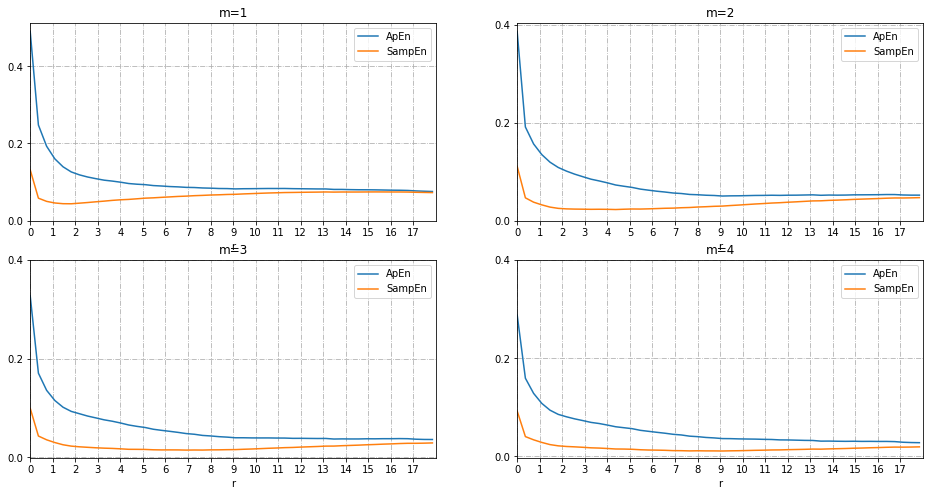

In [11]:


from math import ceil
algos = ['ApEn', 'SampEn']

fig, axs = plt.subplots(2, 2, figsize=(16,8))
max_x = round(max(gf.r))
max_y = round(float(max(gf.apen.append(gf.sampen))),1)
slices_y = int(max_y*10+1)

for m in range(m_min, m_max+1):
    for algo in algos:
        row = int(format(m-1, "b").zfill(2)[0])
        col = int(format(m-1, "b").zfill(2)[1])
        axs[row][col].plot(gf[gf.m==m]['r'], gf[gf.m==m][algo.lower()], label=algo)
        axs[row][col].legend()
        axs[row][col].set_title(f'm={m}', fontsize=12)
        axs[row][col].set_xlabel('r')
        axs[row][col].set_xticks(np.arange(0, max_x, step=1))
        axs[row][col].set_yticks(np.arange(0, max_y, step=0.2))
        axs[row][col].set_xlim(xmin=0, xmax=max_x)
        axs[row][col].grid(True, linestyle='dashdot')